<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/2_show_primer_bias_splitcode_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Align SPLIT-Seq data from lung samples from mice infected with SARS-CoV-2  
# - Visualization of alignment results
Reference: https://doi.org/10.1038/s41586-022-05344-2


### Install software

In [1]:
!pip install -q anndata

import numpy as np
import anndata
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00


### Download count matrices generated in [this notebook](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/1_show_primer_bias_splitcode_alignment.ipynb):

In [2]:
!git clone https://github.com/pachterlab/LSCHWCP_2023.git
out_folder = "LSCHWCP_2023/Notebooks/Supp_Fig_4/Supp_Fig_4c/kb_out"

Cloning into 'LSCHWCP_2023'...
remote: Enumerating objects: 3732, done.
remote: Counting objects: 100% (1027/1027), done.
remote: Compressing objects: 100% (526/526), done.
remote: Total 3732 (delta 917), reused 501 (delta 501), pack-reused 2705 (from 2)
Receiving objects: 100% (3732/3732), 305.91 MiB | 40.05 MiB/s, done.
Resolving deltas: 100% (2024/2024), done.
Updating files: 100% (518/518), done.


## Load generated count matrices and add metadata

In [3]:
srrs = ['SRR18496012',
 'SRR18496013',
 'SRR18496014',
 'SRR18496015',
 'SRR18496016',
 'SRR18496017',
 'SRR18496018',
 'SRR18496019']

Add primer type and well from onlist based on the last 8 bases of barcode:

In [4]:
# Download barcode to well mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/splitseq_bc2well.csv
bc2well = pd.read_csv("splitseq_bc2well.csv")
bc2well

--2025-02-21 03:20:46--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/splitseq_bc2well.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5151 (5.0K) [text/plain]
Saving to: ‘splitseq_bc2well.csv’

splitseq_bc2well.cs 100%[===================>]   5.03K  --.-KB/s    in 0s      

2025-02-21 03:20:47 (83.7 MB/s) - ‘splitseq_bc2well.csv’ saved [5151/5151]



,bci,sequence,uid,well,type
0,1,CATTCCTA,pbs_1239,A1,T
1,2,CTTCATCA,pbs_1205,A2,T
2,3,CCTATATC,pbs_1247,A3,T
3,4,ACATTTAC,pbs_1211,A4,T
4,5,ACTTAGCT,pbs_1218,A5,T
...,...,...,...,...,...
187,188,GTGTGTGT,pbs_1355,H8,R
188,189,TATGCTTC,pbs_1361,H9,R
189,190,ATGGTGTT,pbs_1318,H10,R
190,191,GAATAATG,pbs_1164,H11,R


In [5]:
palmdb_adatas = []

for srr in srrs:
    # Load data
    adata = anndata.read_h5ad(f"{out_folder}/{srr}/counts_unfiltered/adata.h5ad")

    # Add sample name
    adata.obs["srr"] = srr

    # Create new column containing identifying barcode
    adata.obs["iden_bc"] = adata.obs.index.str[-8:]

    # Create copy of barcode column
    adata.obs["barcode"] = adata.obs.index

    # Merge well and primer information
    adata.obs = adata.obs.merge(bc2well, left_on="iden_bc", right_on="sequence", how="left").set_index("barcode", drop=False)

    # Append to adata list
    palmdb_adatas.append(adata)

In [ ]:
# Concatenate datasets
palmdb_adata = palmdb_adatas[0]
for adata_obj in palmdb_adatas[1:]:
    palmdb_adata = palmdb_adata.concatenate(adata_obj,
                             join='outer',
                             batch_key='sample_index',
                             batch_categories=None,
                             uns_merge=None,
                             fill_value=np.nan)

palmdb_adata

In [7]:
# Drop unnecessary/duplicated columns
palmdb_adata.obs = palmdb_adata.obs.drop(["sequence", "sample_index"], axis=1)
palmdb_adata.obs

,srr,iden_bc,barcode,bci,uid,well,type
barcode,,,,,,,
AAACATCGAACAACCAGAGCACAA-0-0-0-0-0-0-0,SRR18496012,GAGCACAA,AAACATCGAACAACCAGAGCACAA,77,pbs_1142,G5,T
AAACATCGAACCGAGAAATTTCTC-0-0-0-0-0-0-0,SRR18496012,AATTTCTC,AAACATCGAACCGAGAAATTTCTC,28,pbs_1115,C4,T
AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T
AAACATCGAACCGAGAGTGGGTTC-0-0-0-0-0-0-0,SRR18496012,GTGGGTTC,AAACATCGAACCGAGAGTGGGTTC,147,pbs_1185,E3,R
AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T
...,...,...,...,...,...,...,...
TTCACGCAGCCACATAGAGGTTGA-1,SRR18496019,GAGGTTGA,TTCACGCAGCCACATAGAGGTTGA,145,pbs_1171,E1,R
TTCACGCAGTACGCAAGGTTCTTC-1,SRR18496019,GGTTCTTC,TTCACGCAGTACGCAAGGTTCTTC,116,pbs_1181,B8,R
TTCACGCAGTACGCAATTATTCTG-1,SRR18496019,TTATTCTG,TTCACGCAGTACGCAATTATTCTG,14,pbs_1118,B2,T


Add metadata:

In [8]:
# Load first set of metadata provided by authors
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/GSM5974202_sample_well_IDs.tsv
meta1 = pd.read_csv("GSM5974202_sample_well_IDs.tsv", sep='\t')
meta1["well_ID_list"] = meta1["well_ID"]
meta1["well_ID"] = meta1["well_ID_list"].str.split("-")
meta1 = meta1.explode("well_ID")
meta1.head()

--2025-02-21 03:20:49--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/GSM5974202_sample_well_IDs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469 [text/plain]
Saving to: ‘GSM5974202_sample_well_IDs.tsv’

GSM5974202_sample_w 100%[===================>]     469  --.-KB/s    in 0s      

2025-02-21 03:20:49 (41.4 MB/s) - ‘GSM5974202_sample_well_IDs.tsv’ saved [469/469]



,sample,well_ID,well_ID_list
0,ctrl_01_E2,A1,A1-A2
0,ctrl_01_E2,A2,A1-A2
1,ctrl_02_E2,A3,A3-A4
1,ctrl_02_E2,A4,A3-A4
2,ctrl_03_E2,A5,A5-A6


In [9]:
# Copy current index
palmdb_adata.obs["barcode_idx"] = palmdb_adata.obs.index.values

In [10]:
palmdb_adata.obs = palmdb_adata.obs.merge(meta1, left_on="well", right_on="well_ID", how="left").drop("well_ID_list", axis=1)
palmdb_adata.obs

,srr,iden_bc,barcode,bci,uid,well,type,barcode_idx,sample,well_ID
0,SRR18496012,GAGCACAA,AAACATCGAACAACCAGAGCACAA,77,pbs_1142,G5,T,AAACATCGAACAACCAGAGCACAA-0-0-0-0-0-0-0,NaN,NaN
1,SRR18496012,AATTTCTC,AAACATCGAACCGAGAAATTTCTC,28,pbs_1115,C4,T,AAACATCGAACCGAGAAATTTCTC-0-0-0-0-0-0-0,inf_05_E4,C4
2,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T,AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,ctrl_09_E4,B5
3,SRR18496012,GTGGGTTC,AAACATCGAACCGAGAGTGGGTTC,147,pbs_1185,E3,R,AAACATCGAACCGAGAGTGGGTTC-0-0-0-0-0-0-0,NaN,NaN
4,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T,AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,ctrl_07_E4,B2
...,...,...,...,...,...,...,...,...,...,...
64431,SRR18496019,GAGGTTGA,TTCACGCAGCCACATAGAGGTTGA,145,pbs_1171,E1,R,TTCACGCAGCCACATAGAGGTTGA-1,NaN,NaN
64432,SRR18496019,GGTTCTTC,TTCACGCAGTACGCAAGGTTCTTC,116,pbs_1181,B8,R,TTCACGCAGTACGCAAGGTTCTTC-1,inf_01_E2,B8
64433,SRR18496019,TTATTCTG,TTCACGCAGTACGCAATTATTCTG,14,pbs_1118,B2,T,TTCACGCAGTACGCAATTATTCTG-1,ctrl_07_E4,B2
64434,SRR18496019,GAGGTTGA,TTCACGCAGTGTTCTAGAGGTTGA,145,pbs_1171,E1,R,TTCACGCAGTGTTCTAGAGGTTGA-1,NaN,NaN


In [11]:
# Load second set of metadata provided by authors
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/GSM5974202_README.txt
meta2 = pd.read_csv("GSM5974202_README.txt", sep='\t')
meta2.head()

--2025-02-21 03:20:50--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_4/Supp_Fig_4c/GSM5974202_README.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2202 (2.2K) [text/plain]
Saving to: ‘GSM5974202_README.txt’

GSM5974202_README.t 100%[===================>]   2.15K  --.-KB/s    in 0s      

2025-02-21 03:20:50 (37.9 MB/s) - ‘GSM5974202_README.txt’ saved [2202/2202]



,Sample_name,title,source_name,organism,APOE_genotype,condition
0,ctrl_01_E2,Non-infected APOE2 mouse rep 01,Lung,Mus musculus,APOE2,non-infected
1,ctrl_02_E2,Non-infected APOE2 mouse rep 02,Lung,Mus musculus,APOE2,non-infected
2,ctrl_03_E2,Non-infected APOE2 mouse rep 03,Lung,Mus musculus,APOE2,non-infected
3,ctrl_04_E3,Non-infected APOE3 mouse rep 01,Lung,Mus musculus,APOE3,non-infected
4,ctrl_05_E3,Non-infected APOE3 mouse rep 02,Lung,Mus musculus,APOE3,non-infected


In [12]:
# Merge second set of metadata into adata object
palmdb_adata.obs = palmdb_adata.obs.merge(meta2, left_on="sample", right_on="Sample_name", how="left").set_index("barcode_idx", drop=True)
palmdb_adata.obs

,srr,iden_bc,barcode,bci,uid,well,type,sample,well_ID,Sample_name,title,source_name,organism,APOE_genotype,condition
barcode_idx,,,,,,,,,,,,,,,
AAACATCGAACAACCAGAGCACAA-0-0-0-0-0-0-0,SRR18496012,GAGCACAA,AAACATCGAACAACCAGAGCACAA,77,pbs_1142,G5,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACATCGAACCGAGAAATTTCTC-0-0-0-0-0-0-0,SRR18496012,AATTTCTC,AAACATCGAACCGAGAAATTTCTC,28,pbs_1115,C4,T,inf_05_E4,C4,inf_05_E4,Infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,infected
AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T,ctrl_09_E4,B5,ctrl_09_E4,Non-infected APOE4 mouse rep 03,Lung,Mus musculus,APOE4,non-infected
AAACATCGAACCGAGAGTGGGTTC-0-0-0-0-0-0-0,SRR18496012,GTGGGTTC,AAACATCGAACCGAGAGTGGGTTC,147,pbs_1185,E3,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCAGCCACATAGAGGTTGA-1,SRR18496019,GAGGTTGA,TTCACGCAGCCACATAGAGGTTGA,145,pbs_1171,E1,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTCACGCAGTACGCAAGGTTCTTC-1,SRR18496019,GGTTCTTC,TTCACGCAGTACGCAAGGTTCTTC,116,pbs_1181,B8,R,inf_01_E2,B8,inf_01_E2,Infected APOE2 mouse rep 01,Lung,Mus musculus,APOE2,infected
TTCACGCAGTACGCAATTATTCTG-1,SRR18496019,TTATTCTG,TTCACGCAGTACGCAATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected


## Plot fractions of virus counts detected per primer type

In [13]:
# Download virus ID to sOTU mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
id2tax_df = pd.read_csv("ID_to_taxonomy_mapping.csv")
id2tax_df.head()

--2025-02-21 03:20:50--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M  --.-KB/s    in 0.1s    

2025-02-21 03:20:51 (141 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]



,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


In [14]:
# Minimum count
threshold_per_cell = 0

In [15]:
# Get fraction of positive cells per virus strandedness per primer type
vtypes = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA or dsRNA']
vlabels = ['+ssRNA', '-ssRNA', 'dsRNA', 'dsDNA', '+ssRNA\nor dsRNA']

t_counts = []
r_counts = []
total_counts = []
for vt in vtypes:
    target_ids = np.unique(id2tax_df[id2tax_df["strandedness"] == vt]["rep_ID"].values)

    # Get counts for poly T primer
    tc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    tc = tc[tc > threshold_per_cell]

    # Get counts for random primers
    rc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    rc = rc[rc > threshold_per_cell]

    # Compute fractions
    t_counts.append(np.sum(tc) / (np.sum(tc) + np.sum(rc)))
    r_counts.append(np.sum(rc) / (np.sum(tc) + np.sum(rc)))

    # Record total count
    total_counts.append(np.sum(tc) + np.sum(rc))

In [16]:
# Get fraction of positive cells for SARS-CoV-2 per primer type
species = [
    "Severe acute respiratory syndrome-related coronavirus",
]

labels = [
    "Severe acute respiratory\nsyndrome-related\ncoronavirus",
]

t_counts_sars = []
r_counts_sars = []
total_counts_sars = []
for sp in species:
    target_ids = id2tax_df[id2tax_df["species"] == sp]["rep_ID"].values

    # Get counts for poly T primer
    tc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    tc = tc[tc > threshold_per_cell]

    # Get counts for random primers
    rc = nd(palmdb_adata[(palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["condition"] == "infected"), palmdb_adata.var.index.isin(target_ids)].X.todense())
    rc = rc[rc > threshold_per_cell]

    # Compute fractions
    t_counts_sars.append(np.sum(tc) / (np.sum(tc) + np.sum(rc)))
    r_counts_sars.append(np.sum(rc) / (np.sum(tc) + np.sum(rc)))

    # Record total count
    total_counts_sars.append(np.sum(tc) + np.sum(rc))

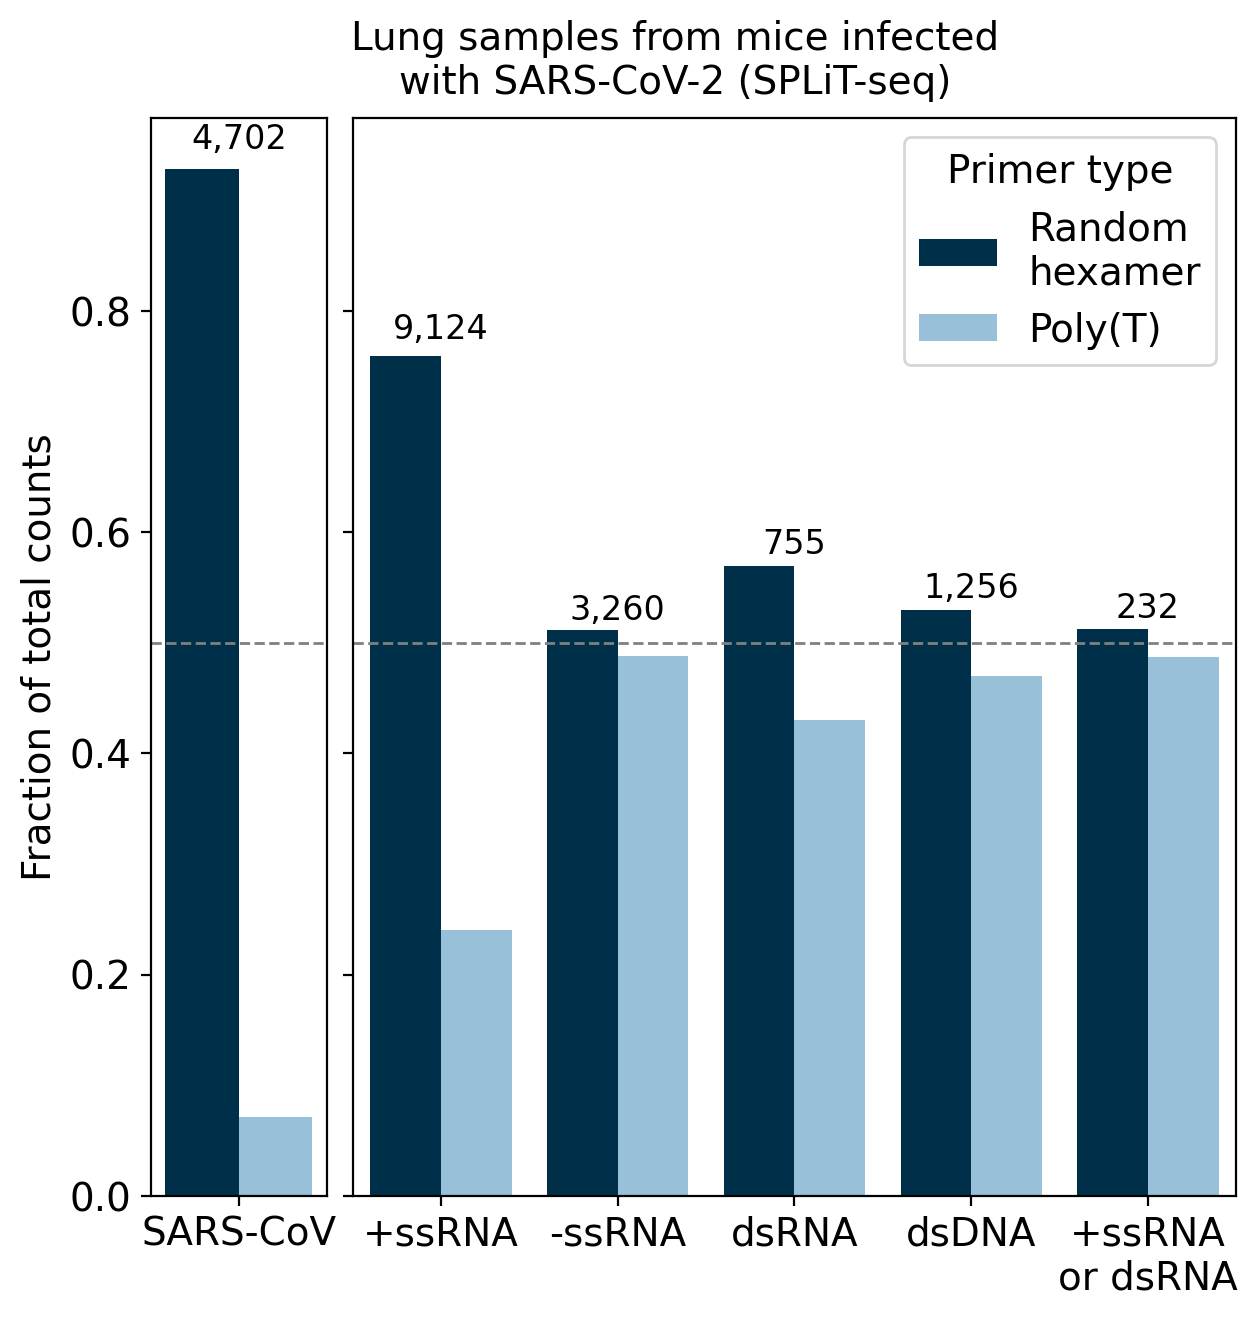

In [17]:
fig, axs = plt.subplots(figsize=(7, 7), ncols=2, sharey=True, gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.05})

fontsize = 14
width = 0.4
colors = ["#003049", "#98c1d9"]

# Plot SARS-CoV2
ax = axs[0]
ax.bar(0-width/2, r_counts_sars[0], width=width, color=colors[0])
ax.bar(0+width/2, t_counts_sars[0], width=width, color=colors[1])
ax.set_xticks([0], ["SARS-CoV"], fontsize=fontsize)

# Add total count above bars
max_bar_height = max(r_counts_sars[0], t_counts_sars[0])
y_pos = max_bar_height + max_bar_height * 0.02  # Adjust the offset dynamically
ax.text(0, y_pos, f"{int(total_counts_sars[0]):,}", ha='center', fontsize=fontsize-2)

# ax.set_xlabel("Known viral infection", fontsize=fontsize)
ax.set_ylabel("Fraction of total counts", fontsize=fontsize)
ax.set_xmargin(0.1)

# Plot general strandedness
ax = axs[1]
x = np.arange(len(vtypes))
ax.bar(x-width/2, r_counts, width=width, color=colors[0], label="Random\nhexamer")
ax.bar(x+width/2, t_counts, width=width, color=colors[1], label="Poly(T)")

# Add total count above bars
for i, x_pos in enumerate(x):
    max_bar_height = max(r_counts[i], t_counts[i])
    y_pos = max_bar_height + max_bar_height * 0.02  # Adjust the offset dynamically
    ax.text(x_pos, y_pos, f"{int(total_counts[i]):,}", ha='center', fontsize=fontsize-2)

ax.legend(title="Primer type", fontsize=fontsize, title_fontsize=fontsize)
ax.set_xticks(np.arange(len(vlabels)), vlabels, fontsize=fontsize)
ax.set_xmargin(0.02)

for ax in axs:
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axhline(0.5, lw=1, ls="--", c="grey")

fig.suptitle("Lung samples from mice infected\nwith SARS-CoV-2 (SPLiT-seq)", fontsize=fontsize, y=0.95)

fig.savefig("random_vs_polyT_final.png", dpi=300, bbox_inches="tight")
fig.savefig("random_vs_polyT_final.pdf", dpi=300, bbox_inches="tight")

fig.show()